In [189]:
import os
import torch
import random
import configs
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
configs.set_seed(42)

In [3]:
device = configs.set_device(0)

There are 8 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-80GB


In [4]:
import open_clip
import clip
from open_clip import tokenizer

clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai', device=device)

clip_model.eval()
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 149,620,737
Context length: 77
Vocab size: 49408


**dataset**

In [5]:
from datasets import load_dataset

dataset = load_dataset("Andron00e/CUB200-custom")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/11788 [00:00<?, ? examples/s]

In [17]:
classes = {}
for i in range(len(dataset["train"].features['labels'].names)):
    classes[i] = dataset["train"].features['labels'].names[i]

**embeds**

In [19]:
import os
from PIL import Image
from tqdm.auto import tqdm

class_images_dict = {}

for i in tqdm(range(len(dataset["train"]))):
    label = classes[dataset["train"][i]["labels"]]
    image = dataset["train"][i]["image"]
    
    if label not in class_images_dict:
        class_images_dict[label] = [image]
    else:
        class_images_dict[label].append(image)

  0%|          | 0/11788 [00:00<?, ?it/s]

In [ ]:
class_images_dict_processed = {}

for label in tqdm(list(class_images_dict.keys())): 
    preprocessed_images = []
    for image in tqdm(class_images_dict[label]):
        im_input = preprocess(image).unsqueeze(0).to(device)
        preprocessed_images.append(im_input)
     
    preprocessed_images = torch.stack(preprocessed_images, dim=0)
    class_images_dict_processed[label] = preprocessed_images 

In [ ]:
with torch.no_grad():
    for label in tqdm(class_images_dict_processed): 
        image_encodings = []
        for image in tqdm(class_images_dict_processed[label]):
            image_feature = clip_model.encode_image(image)
            image_encodings.append(image_feature)
        image_features = torch.stack(image_encodings, dim=0)
        class_images_dict_processed[label] = image_features #torch.mean(image_features, dim=0)

In [31]:
class_encodings = []
with torch.no_grad():
    for label in tqdm(class_images_dict):
        text_input = clip.tokenize(label).to(device)
        text_feature = clip_model.encode_text(text_input)
        class_encodings.append(text_feature)
        
class_features = torch.stack(class_encodings, dim=0)

  0%|          | 0/200 [00:00<?, ?it/s]

**KMeans**

In [118]:
all_image_features = torch.stack([v for v in class_images_dict_processed.values() if v.shape[0] == 60], dim=0)
all_image_features = all_image_features.squeeze(dim=2).cpu()
all_image_features.shape

torch.Size([144, 60, 512])

In [119]:
all_image_features = all_image_features.view(144 * 60, 512)

In [70]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=144, random_state=0, n_init="auto").fit(all_image_features)

In [208]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def reduce_data_dim(data, method: str="pca", n_components: int=2):
    if method.lower() == "pca":
        pca = PCA(n_components=n_components)
        data = pca.fit_transform(data)
    elif method.lower() == "tsne":
        tsne = TSNE(n_components=n_components)
        data = tsne.fit_transform(data)
    return data

def draw_kmeans(kmeans: sklearn.cluster._kmeans.KMeans, features, dataset_name: str, method: str="pca"):
    x, y = reduce_data_dim(features, method=method)[:, 0], reduce_data_dim(features, method=method)[:, 1]
    plt.scatter(x, y, c=kmeans.labels_, cmap='rainbow', marker='o', alpha=0.5) #'viridis'  'rainbow'
    plt.title(f'KMeans Clusters for {dataset_name}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

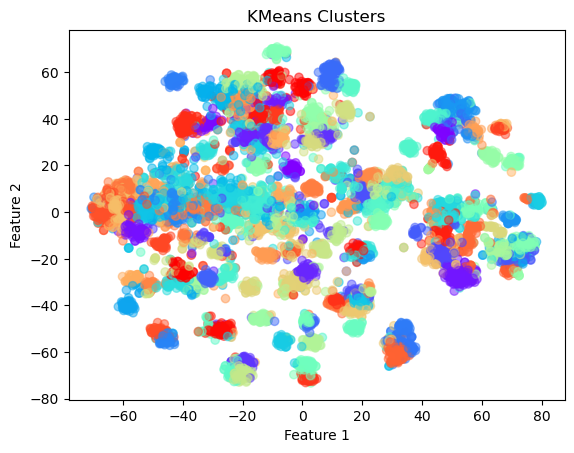

In [205]:
draw_kmeans(kmeans, all_image_features, "tsne")

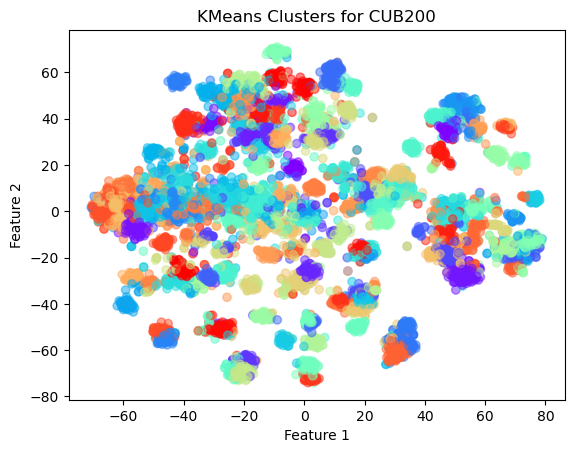

In [213]:
draw_kmeans(kmeans, all_image_features, "CUB200", "tsne")

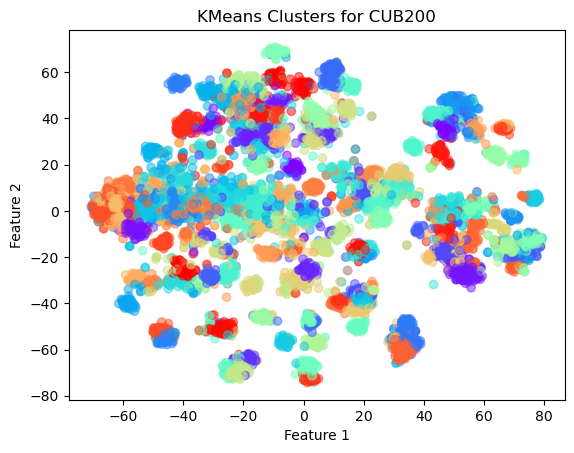

In [223]:
kmeans2 = KMeans(n_clusters=144, random_state=0, n_init="auto", max_iter=500).fit(all_image_features)
draw_kmeans(kmeans2, all_image_features, "CUB200", "tsne")

In [224]:
def draw_kmeans_test(features, dataset_name: str, method: str="pca", max_iter: int=300):
    kmeans = KMeans(n_clusters=144, random_state=0, n_init="auto", max_iter=max_iter).fit(features)
    x, y = reduce_data_dim(features, method=method)[:, 0], reduce_data_dim(features, method=method)[:, 1]
    plt.scatter(x, y, c=kmeans.labels_, cmap='rainbow', marker='o', alpha=0.5) #'viridis'  'rainbow'
    plt.title(f'KMeans Clusters for {dataset_name}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

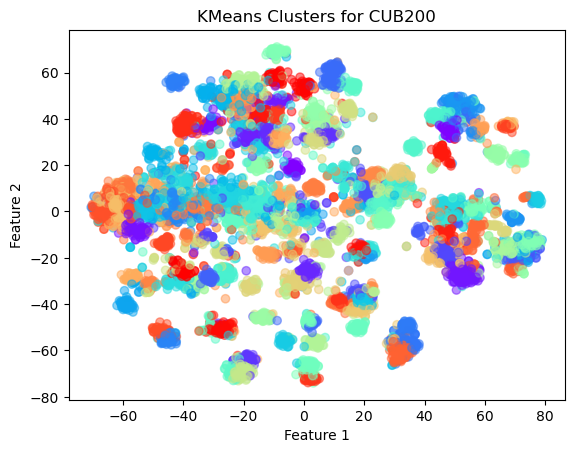

In [225]:
draw_kmeans_test(all_image_features, "CUB200", "tsne")

In [ ]:
draw_kmeans_test(all_image_features, "CUB200", "tsne", max_iter=1000)

In [27]:
def compute_kmeans_acc(image_features, true_labels):
    kmeans = KMeans(n_clusters=200, n_init=10).fit(image_features)
    cluster_agreement = max(
        (kmeans.labels_ == true_labels).mean(), (kmeans.labels_ != true_labels).mean()
    )
    return cluster_agreement

**tSNE**

In [ ]:
from typing import Union
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [155]:
image_features_iv = []
for label in class_images_dict_processed:
    image_features_iv.append(class_images_dict_processed[label][:41])

In [156]:
image_features_iv = torch.stack(image_features_iv, dim=0)
image_features_iv = image_features_iv.squeeze(dim=2).cpu()
image_features_iv = image_features_iv.view(-1, image_features_iv.size(-1))
image_features_iv.shape

torch.Size([8200, 512])

In [157]:
class_features_wv = class_features.squeeze(dim=1).cpu()
class_features_wv.shape

torch.Size([200, 512])

In [180]:
image_and_classes_names = [item for item in list(class_images_dict.keys()) for _ in range(41)] + list(class_images_dict.keys())

In [184]:
scaler = StandardScaler()

data_to_draw = torch.vstack([image_features_iv, class_features_wv])
tsne = TSNE(n_components=2, learning_rate='auto', 
            init='random', perplexity=50)

data_tsne = tsne.fit_transform(data_to_draw)
data_tsne = scaler.fit_transform(data_to_draw)

image_colors = ['red'] * len(image_features_iv)
class_colors = ['blue'] * len(class_features_wv)
colors = image_colors + class_colors

draw_vectors(data_tsne[:, 0], data_tsne[:, 1], color=colors, token=image_and_classes_names)

figure(id='p1004', ...)

100 perplexity

In [185]:
scaler = StandardScaler()

data_to_draw = torch.vstack([image_features_iv, class_features_wv])
tsne = TSNE(n_components=2, learning_rate='auto', 
            init='random', perplexity=100)

data_tsne = tsne.fit_transform(data_to_draw)
data_tsne = scaler.fit_transform(data_to_draw)

image_colors = ['red'] * len(image_features_iv)
class_colors = ['blue'] * len(class_features_wv)
colors = image_colors + class_colors

draw_vectors(data_tsne[:, 0], data_tsne[:, 1], color=colors, token=image_and_classes_names)

figure(id='p1049', ...)

150 perplexity

In [186]:
scaler = StandardScaler()

data_to_draw = torch.vstack([image_features_iv, class_features_wv])
tsne = TSNE(n_components=2, learning_rate='auto', 
            init='random', perplexity=150)

data_tsne = tsne.fit_transform(data_to_draw)
data_tsne = scaler.fit_transform(data_to_draw)

image_colors = ['red'] * len(image_features_iv)
class_colors = ['blue'] * len(class_features_wv)
colors = image_colors + class_colors

draw_vectors(data_tsne[:, 0], data_tsne[:, 1], color=colors, token=image_and_classes_names)

figure(id='p1094', ...)

200 perplexity

In [187]:
scaler = StandardScaler()

data_to_draw = torch.vstack([image_features_iv, class_features_wv])
tsne = TSNE(n_components=2, learning_rate='auto', 
            init='random', perplexity=200)

data_tsne = tsne.fit_transform(data_to_draw)
data_tsne = scaler.fit_transform(data_to_draw)

image_colors = ['red'] * len(image_features_iv)
class_colors = ['blue'] * len(class_features_wv)
colors = image_colors + class_colors

draw_vectors(data_tsne[:, 0], data_tsne[:, 1], color=colors, token=image_and_classes_names)

figure(id='p1139', ...)

In [191]:
def draw_vectors_test(x, y, radius=10, alpha=0.25, color='blue', marker='circle',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxiliary info on hover """
    if isinstance(color, str):
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({'x': x, 'y': y, 'color': color, 'marker': marker, **kwargs})

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    scatter = fig.scatter('x', 'y', size=radius, color='color', marker='marker', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [ ]:
data_to_draw = torch.vstack([image_features_iv, class_features_wv])


tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=200)
data_tsne = tsne.fit_transform(data_to_draw)

scaler = StandardScaler()
data_tsne = scaler.fit_transform(data_tsne)

#image_colors = ['red'] * len(image_features_iv)
#class_colors = ['blue'] * len(class_features_wv)
#colors = image_colors + class_colors
class_colors = [f"#{i:02X}0000" for i in image_labels]
colors = class_colors + ['green'] * len(class_features_wv)
markers = ['circle'] * len(image_features_iv) + ['square'] * len(class_features_wv)

draw_vectors_test(data_tsne[:, 0], data_tsne[:, 1], color=colors, marker=markers, token=labels.numpy())

In [202]:
import secrets

def generate_random_color():
    color = "#{:06x}".format(secrets.randbelow(0xFFFFFF))
    return color

random_colors = [generate_random_color() for _ in range(200)]
random_colors = [item for item in random_colors for _ in range(41)]

In [204]:
scaler = StandardScaler()

data_to_draw = torch.vstack([image_features_iv, class_features_wv])
tsne = TSNE(n_components=2, learning_rate='auto', 
            init='random', perplexity=200)

data_tsne = tsne.fit_transform(data_to_draw)
data_tsne = scaler.fit_transform(data_to_draw)

image_colors = random_colors#[f"#{i:02X}0000" for i in torch.arange(0, 8200 // 41).repeat(41)]
class_colors = ['blue'] * len(class_features_wv)
colors = image_colors + class_colors

markers = ['circle'] * len(image_features_iv) + ['square'] * len(class_features_wv)

draw_vectors_test(data_tsne[:, 0], data_tsne[:, 1], color=colors, marker=markers, token=image_and_classes_names)

figure(id='p1232', ...)

300 perplexity

In [216]:
scaler = StandardScaler()

data_to_draw = torch.vstack([image_features_iv, class_features_wv])
tsne = TSNE(n_components=2, learning_rate='auto', 
            init='random', perplexity=300)

data_tsne = tsne.fit_transform(data_to_draw)
data_tsne = scaler.fit_transform(data_to_draw)

image_colors = random_colors
class_colors = ['blue'] * len(class_features_wv)
colors = image_colors + class_colors

markers = ['circle'] * len(image_features_iv) + ['square'] * len(class_features_wv)

draw_vectors_test(data_tsne[:, 0], data_tsne[:, 1], color=colors, marker=markers, token=image_and_classes_names)

figure(id='p1277', ...)